In [1]:
!pip install mne

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 14.6 MB/s 


In [2]:
!pip install pymatreader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Core Class (import)

In [ ]:
#core class - imports the files information
from joblib import load as jLoad
import numpy as np
from numpy import genfromtxt, array, savetxt, argmax
from numpy.random import randint
from pickle import load as pLoad
from mne.io import read_raw_edf, read_raw_eeglab
from os import listdir
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix

#sem os dois imports de classes internas ao projeto


'''
    Cria uma matriz EEG de dimensões t x c x l, onde 't' é o número de ensaios, 'c' é o número de canais e 'l' é o tamanho da gravação.

    Parameters
    ----------
    directory : str
        Nome do diretório que contêm os ensaions do sujeito que deve ser agrupado em uma matriz singular.
        
    fix_length : bool, optional
        Verdadeiro se os ensaios tem tamanhos diferentes, falso caso contrário. O valor padrão é falso.
    length : int, optional
        Tamanho a ser usado em todos os ensaios. Isso deve ser especificado se o "fix_length" for True. O valor padrão é None.
        
    row_channels : bool, optional
        Veradeiro se as linhas de cada ensaio corresponderem aos canais, falso caso contrário. O valor padrão é True.

    Raises
    ------
    TypeError
        Se os parâmetros ou arquivos possuem tipo não suportado.
    RuntimeError
        Se um erro ocorrer para prevenir o funcionamento correto.

    Returns
    -------
    eeg_matrix : ndarray
        Matriz EEG de dimensões t x c x l.

    '''

def create_eeg_matrix(directory, fix_length=False, length=None, row_channels=True):
    
    ## Validaçõe iniciais dos valores de entrada ##
    if type(directory) != str:
        raise TypeError(f"'directory' deve ser do tipo 'str', tipo recebido: '{type(directory).__name__}'")
    if type(fix_length) != bool:
        raise TypeError(f"'fix_length' deve ser do tipo 'bool', tipo recebido: '{type(fix_length).__name__}'")
    if fix_length:
        if (type(length) != int and type(length) != float) or (int(length) != length):
            raise TypeError(f"'length' deve ser do tipo 'int', tipo recebido: '{type(length).__name__}'")
        if length < 1:
            raise TypeError(f"'length' deve ser maior que '0', valor recebido: {length}")
        length = int(length)
    
    if type(row_channels) != bool:
        raise TypeError(f"'row_channels' deve ser do tipo 'bool', tipo recebido: '{type(row_channels).__name__}'")


        ## Listando o número de amostras ##
    try:
      files = os.listdir(f"{gdrive_path}/{trial}")
      print("Trial atual:" + trial)
    except:
        raise

    eeg_matrix = []
    trial_length = None
    ## Validaçõe dos arquivos no diretório de cada amostra ##
    if len(trials) == 0:
      raise RuntimeError("Diretório vazio não pode ser convertido em uma matriz EEG")

    for eeg_file in files:
      
      if "." not in eeg_file:
        raise TypeError(f"File type of '{eeg_file}' not found")

      file_type = eeg_file.split(".")[-1] 

      if file_type == "set":
      #Necessário deixar apenas os arquivos eeg dentro da pasta de amostra
      #if file_type not in ["sav", "csv", "dat", "edf", "set", "fdt"]:
      #  raise TypeError(f"Tipo de arquivo '{trial}' não suprotado. TIpos suportados: sav, csv, dat, edf")
      
        # Verifica o tipo do arquivo e realiza sua importação
        try:
       
          raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")
          data = array(raw_data.get_data())
          print(np.shape(data))

        except:
          raise

        # Verifica condição de parâmetro de entrada inicial
        if not row_channels:
          data = data.T

        if fix_length:
          if len(data[0]) < length:
            raise RuntimeError(f"Todas as amostras deve ter pelo menos {length} de tamanho")
          data = data[:,:length]

          #teste de conteudo na variavel data
        else:
          if  trial_length == None:
            trial_length = len(data[0])
          #else:
            #if len(data[0]) != trial_length:
            #  raise RuntimeError("Todas as amostras devem ter o mesmo tamanho")
        
        eeg_matrix.append(data)
         #print(raw_data.info.get('nchan'))
  
    return array(eeg_matrix, order='A', dtype= float)


In [ ]:
#time windowing class
'''
    Segmenta uma matriz EEG em janelas de tempo específicas

    Parameters
    ----------
    eeg_matrix : ndarray
        Uma matriz EEG de dimensções t x c x l, onde 't' corresponde ao número de ensaios, 'c' ao número de canais e 'l' é o tamanho da gravação. 
    frequency : int
        Frequência de amostragem utilziada para a gravação da matriz EEG.
    time_windows : list
        Janela de tempo, em segundos, na qual os ensaios foram segmentados
    start_type : str, optional
        Método para selecionar o início da segmentação, isso pode ser: 'begin' (segmentação começa no começo da gravação), 'random' (segmentação começa de um ponto aleatório da gravação), 
        ou 'custom' (permite a definição do momento exato para começar a segmentação). O valor padrão é 'begin'.
    start_time : list, optional
        Especifica o ponto, em segundos, de iníco da segmentação de cada ensaio. Pode ser especificado apenas se 'start_type' for 'custom'. O valor padrão é None.
    channels : list, optional
        Lista de canais para usar na segmentação, se None, então todos os canais são usados. O valor padrão é None.
    verbose : bool, optional
        True para receber informação durante o processo de segmentação, False caso contrário. O valor padrão é Ture.

    Raises
    ------
    TypeError
        Se os parâmetros tem tipos não suportados.
    RuntimeError
        Se ocorrer um erro que impede o funcionamento.

    Returns
    -------
    time_segmented_matrices : list
        Lista com as matrizes segmentadas correspondentes a cada janela de tempo.
'''

def time_windowing(eeg_matrix, frequency, time_windows, start_type="begin", start_time=None, channels=None, verbose=True):
  
    # Validações da matriz de entrada: eeg_matrix
    if type(eeg_matrix).__name__ != "ndarray" and type(eeg_matrix) != list:
      raise TypeError(f"'eeg_matrix' must be 'ndarray', received: '{type(eeg_matrix).__name__}'")
    if type(eeg_matrix) == list:
     eeg_matrix = array(eeg_matrix)
    if "float" not in eeg_matrix.dtype.name and "int" not in eeg_matrix.dtype.name:
      raise TypeError(f"All elements of 'eeg_matrix' must be numbers")
    if len(eeg_matrix.shape) != 3:
       raise TypeError(f"'eeg_matrix' must be an matrix of dimensions t x c x l, received: {eeg_matrix.shape}")

    #Validações do parâmetro de entrada: frequency (frequência de amostragem)
    if (type(frequency) != int and type(frequency) != float) or (int(frequency) != frequency):
        raise TypeError(f"'frequency' must be 'int', received: '{type(frequency).__name__}'")
    if frequency < 1:
        raise TypeError(f"'frequency' must be greater than 0, received: {frequency}")
    frequency = int(frequency)

    #Validações do parâmetro de entrada: time_windows (janela de tempo)
    if type(time_windows).__name__ != "ndarray" and type(time_windows) != list:
        raise TypeError(f"'time_windows' must be list of numbers, received: '{type(time_windows).__name__}'")
    if type(time_windows) == list:
        time_windows = array(time_windows)
    if "float" not in time_windows.dtype.name and "int" not in time_windows.dtype.name:
        raise TypeError(f"All elements of 'time_windows' must be numbers")
    for time_window in time_windows:
        if not (time_window > 0):
            raise TypeError(f"All time windows must be greater than 0, received: {time_window}")

    #Validações do parâmetro de entrada: start_type (tipo de início da janela de tempo)
    if start_type not in ["begin", "random", "custom"]:
        raise TypeError(f"Invalid 'start_type' must be 'begin', 'random', or 'custom', received: '{start_type}'")
    if start_type == "custom":
        if type(start_time).__name__ != "ndarray" and type(start_time) != list:
            raise TypeError(f"'start_time' must be list of numbers, received: '{type(start_time).__name__}'")
     #   if not (start_time > 0):
     #       raise TypeError(f"'start_time' must be greater than 0, received: {start_time}")
     #   start = int(start_time*frequency)

    #Validações do parâmetro de entrada: channles (canais que serão seguimentados)
    if type(channels) != list and channels != None:
        raise TypeError(f"'channels' must be list of integers, received: '{type(channels).__name__}'")
    if channels != None:
        for channel in channels:
            if type(channel) != int:
                raise TypeError(f"'channels' must be list of integers, received: '{type(channel).__name__}' inside the list")
            if channel < 0:
                raise TypeError(f"All channels must be greater or equal to 0, received: {channel}")    

    #Validações do parâmetro de entrada: verbose
    if type(verbose) != bool:
      raise TypeError(f"'verbose' must be 'bool', received: '{type(verbose).__name__}'")

    #Validações de janela de tempo
    recording_length = len(eeg_matrix[0,0])
    total_recording_time = recording_length/frequency

    for time in time_windows:
      if time > total_recording_time:
        raise RuntimeError(f"All time windows must be less than or equal to {total_recording_time} seconds because it is the maximum recording time available in the input EEG matrix")
        

    #Segmentação do sinal em janelas de tempo
    time_segmented_matrices = []

    #apenas uma iteração
    for time in time_windows:
      #if verbose: print(f"Início time_windowing")
      time_length = int(time*frequency)

      time_segmented_matrix = []

      #apenas uma iteração
      for trial in range(len(eeg_matrix)):
        #print(len(eeg_matrix))
        #print(trial)
        
        if(time+start_time[trial]) > total_recording_time:
          raise RuntimeError(f"All time windows must be less than or equal to {total_recording_time-start_time[trial]} seconds because it is the maximum recording time available in the input EEG matrix minus the specified start time")
        #Deve ser um int pois vai ser utilizado como index 
        start = int(start_time[trial]*frequency)
        try:
          if channels == None:
              if start_type == "begin":
                segmented_trial = eeg_matrix[trial][:,:time_length]
              elif start_type == "random":
                print(f"Recording {trial} and {start_time[trial]} in segmented_trial")
                random_start =  randint(0, recording_length-time_length+1)
                segmented_trial = eeg_matrix[trial][:,random_start:random_start+time_length]
              else:
                #Start_type = 'Custom', utiliza o start_time refente ao trial
                segmented_trial = eeg_matrix[trial][:,start:start+time_length]

          #Se os canais forem cortados de forma diferente
          else:
            segmented_trial = []
            try:
                if start_type == "random":        
                  random_start =  randint(0, recording_length-time_length+1)
                for channel in channels:
                    if start_type == "begin":
                      segmented_trial.append(eeg_matrix[trial][channel,:time_length])
                    elif start_type == "random":        
                      segmented_trial.append(eeg_matrix[trial][channel,random_start:random_start+time_length])
                    else:
                      segmented_trial.append(eeg_matrix[trial][channel,start:start+time_length])
            except:
              raise
            segmented_trial = array(segmented_trial)
          
        except:
          raise

        #Registro de sucesso da segmentação
        time_segmented_matrix.append(segmented_trial)
      # if verbose: print(f"Amostra {trial} segmentada corretamente")

      time_segmented_matrices.append(array(time_segmented_matrix))
      if verbose: print(f"Fim do método")
      #if verbose: print(f"{'*'*49}\n")
    
    return time_segmented_matrix








In [ ]:
#padding e restauração do sinal (utilizado no método dwt)
from pywt import Wavelet
from math import floor, ceil
from numpy import concatenate, flipud, zeros, convolve, array

'''
    Aplica um preenchimento simétrico do tamanho especificado para o sinal de entrada.
    OBS: técnica de zero-pad anterior a aplicação de uma transformada, adicionar zeros para preencher o sinal.
    Zero padding allows one to use a longer FFT, which will produce a longer FFT result vector.

    Parametros
    ----------
    signal : ndarray
        O sinal a ser preenchido.
    size : int, opcional
        O tamanho do preenchimento o qual corresponde ao tamanho do filtro. O valor padrão é 8. 
      
    Retornos
    -------
    padded_signal : ndarray
        Sinal preenchido.

    '''
def padding_symmetric(signal, size=1):

  padded_signal = concatenate([flipud(signal[:size]), signal, flipud(signal[-size:])])

  return padded_signal

'''
    Restaura o sinal para seu tamanho original usando o filtro de reconstrução.

    Parameters
    ----------
    signal : ndarray
        O signal que será restaurado.
    reconstruction_filter : list
        O filtro de reconstrução que será utilizado para restaurar o sinal.
    real_len : int
        O comprimento real do sinal.

    Returns
    -------
    restored_signal : ndarray
        O sinal restaurado de comprimento especificado.

    '''
def restore_signal(signal, reconstruction_filter, real_len):

  restored_signal = zeros(2 * len(signal) + 1)
  for i in range(len(signal)):
    restored_signal[i * 2 + 1] = signal[i]
  #print(f'real_len = {real_len}')
  restored_signal = convolve(restored_signal, reconstruction_filter)
  restored_len = len(restored_signal)
  exceed_len = (restored_len - real_len) / 2
  restored_signal = restored_signal[int(floor(exceed_len)):(restored_len - int(ceil(exceed_len)))]

  return restored_signal


In [ ]:
#método dwt - extrai as características do sinal após o método time_windowing
from pywt import Wavelet
from math import floor, ceil
'''
    Aplica uma Transformada Wavelet Discreta no sinal.
    
    Parameters
    ----------
    signal : ndarray
        O sinal no qual a DWT será aplicada.
    level : int, optional
        Os níveis de decomposição para a DWT. O padrão é 3.
    mother_wavelet : str, optional
        A wavelet-mãe que será usada na DWT. A padrão é "db4".

    Returns
    -------
    restored_approx_coeff : list
        Armazena os coeficientes de aproximação.
    restored_detail_coeff : list
        Armazena os coeficientes detalhados.

    '''
def dwt(signal, level=3, mother_wavelet='db4'):
  if type(signal).__name__ != 'ndarray' and type (signal) != list:
    raise TypeError(f"'signal' must be 'ndarray', received: '{type(signal).__name__}'")
  if type(signal) == list:
        signal = array(signal)
  if "float" not in signal.dtype.name and "int" not in signal.dtype.name:
        raise TypeError(f"All elements of 'signal' must be numbers")
  if type(level) != int:
        raise TypeError(f"'level' must be 'int', received: '{type(level).__name__}'")
  if level < 1:
      raise TypeError(f"'level' must be greater than 0, received: {level}")
  
  mother_wavelet_matrix = ['haar', 'db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8', 'db9', 'db10', 'db11', 'db12', 'db13', 'db14', 'db15',
                            'db16', 'db17', 'db18', 'db19', 'db20', 'db21', 'db22', 'db23', 'db24', 'db25', 'db26', 'db27', 'db28', 'db29', 'db30', 'db31', 'db32', 'db33', 'db34',
                            'db35', 'db36', 'db37', 'db38', 'sym2', 'sym3', 'sym4', 'sym5', 'sym6', 'sym7', 'sym8', 'sym9', 'sym10', 'sym11', 'sym12', 'sym13', 'sym14', 'sym15', 'sym16', 'sym17',
                            'sym18', 'sym19', 'sym20', 'coif1', 'coif2', 'coif3', 'coif4', 'coif5', 'coif6', 'coif7', 'coif8', 'coif9', 'coif10', 'coif11', 'coif12', 'coif13', 'coif14', 'coif15', 'coif16', 'coif17',
                            'bior1.1', 'bior1.3', 'bior1.5', 'bior2.2', 'bior2.4', 'bior2.6', 'bior2.8', 'bior3.1', 'bior3.3', 'bior3.5', 'bior3.7', 'bior3.9', 'bior4.4', 'bior5.5', 'bior6.8', 'rbio1.1', 'rbio1.3', 'rbio1.5',
                            'rbio2.2', 'rbio2.4', 'rbio2.6', 'rbio2.8', 'rbio3.1', 'rbio3.3', 'rbio3.5', 'rbio3.7', 'rbio3.9', 'rbio4.4', 'rbio5.5', 'rbio6.8', 'dmey', 'gaus1', 'gaus2', 'gaus3', 'gaus4', 'gaus5', 'gaus6', 'gaus7',
                            'gaus8', 'mexh', 'morl', 'cgau1', 'cgau2', 'cgau3', 'cgau4', 'cgau5', 'cgau6', 'cgau7', 'cgau8', 'shan', 'fbsp', 'cmor']
  if mother_wavelet not in mother_wavelet_matrix:
      raise TypeError("'mother_wavelet' inválida, deve ser " + mother_wavelet_matrix + f" , recebido: '{mother_wavelet}'")

  original_len = len(signal)
  approx_coeff = []
  detail_coeff = []
  wavelet = Wavelet(mother_wavelet)
  low_filter = wavelet.dec_lo
  high_filter = wavelet.dec_hi
  filter_size = len(low_filter)

  try:
    #loop conforme os níveis de decomposição estipulados
    for _ in range(level):

      padded_signal = padding_symmetric(signal, filter_size)

      #aplicação dos filtros passa alta e passa baixa
      low_pass_filtered_signal = convolve(padded_signal, low_filter)[filter_size:(2*filter_size)+len(signal)-1] 
      low_pass_filtered_signal = low_pass_filtered_signal[1:len(low_pass_filtered_signal):2]
      high_pass_filtered_signal = convolve(padded_signal, high_filter)[filter_size:filter_size+len(signal)+filter_size-1]
      high_pass_filtered_signal = high_pass_filtered_signal[1:len(high_pass_filtered_signal):2]

      #armazenando os coeficientes detalhados e aproximados
      approx_coeff.append(low_pass_filtered_signal)
      detail_coeff.append(high_pass_filtered_signal)

      signal = low_pass_filtered_signal
  except:
    raise

  low_reconstruction_filter = wavelet.rec_lo
  high_reconstruction_filter = wavelet.rec_hi
  real_lengths = []

  for i in range(level-2,-1,-1):
    real_lengths.append(len(approx_coeff[i]))
  
  real_lengths.append(original_len)
  restored_approx_coeff = []

  for i in range(level):
    restored_signal = restore_signal(approx_coeff[i], low_reconstruction_filter, real_lengths[level-1-i])
    for j in range(i):
      restored_signal = restore_signal(restored_signal, low_reconstruction_filter, real_lengths[level-1-j])
    restored_approx_coeff.append(restored_signal)
  restored_detail_coeff = []

  for i in range(level):
      restored_signal = restore_signal(detail_coeff[i], high_reconstruction_filter, real_lengths[level-1-i])
      for j in range(i):
          restored_signal = restore_signal(restored_signal, high_reconstruction_filter, real_lengths[level-i-j])
      restored_detail_coeff.append(restored_signal)
  return restored_approx_coeff, restored_detail_coeff




In [ ]:
#CLASSE MAIN
from numpy.lib.twodim_base import tril_indices
import pandas as pd
import csv
import numpy as np
from numpy import array
import os, os.path
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA, FastICA
import matplotlib.pyplot as plt
from google.colab import drive
import os, os.path
import matplotlib.pyplot as plt

#realizando o mount com o google drive
drive.mount('/content/gdrive', force_remount=True)
gdrive_path = '/content/gdrive/MyDrive/Colab_Notebooks/TCC2_repository/DataSet_DENS/trials'

#definindo os valores de entrada time_windowing
time_window = [int(15124.5/250)]
frequency = 250
start_type = 'custom'

#dados inicias da dwt
level=5
mother_wavelet='sym6'


#importando o tempo de início de cada estímulo
stimulus_path = '/content/gdrive/MyDrive/Colab_Notebooks/TCC2_repository/estimulos/all_stimulus.csv'
time_file = pd.read_csv(f'{stimulus_path}', delimiter=';')
trial_data = array(pd.DataFrame(time_file, columns= ['trial'],dtype= str))
time_data = array(pd.DataFrame(time_file, columns= ['time'], dtype=float))
label_data = array(pd.DataFrame(time_file, columns= ['label'], dtype=str))



#lista e ordena os ensaios no diretório no google drive
trials = os.listdir(gdrive_path)
trials.sort()
print(trials)
print(len(trials))

#variável de iteração para controle dos cortes de cada amostra
i = 0
 
error_trials = []
matrix_guide = []
all_segmented_signals = []
truncated_segmented_signals = []



#loop para criar a matriz de cada sinal e segmentá-la de acordo com os eventos
for trial in trials:
  eeg_matrix = create_eeg_matrix(gdrive_path)
  print(50*"*")

  segmented_full = []
  #loop para segmentar os eventos
  for trial_value in trial_data:

    #condição para verificar quantos eventos cada ensaio poussi no arquivo EEG
    if int(trial_value) == int(trial.split('t')[-1]):
      time_stimulus = time_data[i]
      label_stimulus = label_data[i]
      i+=1
      print("Ensaio" + (trial.split('t')[-1]) + ": ")
      print(time_stimulus)

      recording_length = len(eeg_matrix[0,0])
      total_recording_time = recording_length/frequency
      
      #referência de ensaios com erro
      if(total_recording_time < time_stimulus+time_window):
        error_trial = (int(trial_value), str(label_stimulus) ,float(time_stimulus))
        error_trials.append(error_trial)
                        
      else:
        #armazena os eventos segmentados em ordem
        segmented_matrix = time_windowing(eeg_matrix, frequency, time_window, start_type, time_stimulus)
        guide = (int(trial_value), str(label_stimulus) ,float(time_stimulus))
        matrix_guide.append(guide)
        segmented_full.append(segmented_matrix)
  
  #armazena os grupos de eventos segmentados
  all_segmented_signals.append(segmented_full)

#salva matriz com sinais já segmentados no drive
np.save("/content/gdrive/MyDrive/Colab_Notebooks/TCC2_repository/resultados/all_segmented_signals.npy", all_segmented_signals)

#log de sucesso, retornando o formato das matrizes resultantes
print(f"Junção dos sinais full: {np.shape(all_segmented_signals)}")
print("Sucesso!")
print(f"Erro trials: {np.shape(error_trials)}")
print(f"Matrix_guide: {np.shape(matrix_guide)}")

#gerando arquivo de guia para os eventos que foram armazenados na matriz e seus respectivos tempos de início.
df = pd.DataFrame({'Trial': matrix_guide[0]})
error_matrix = np.matrix(error_trials)
print(matrix_guide)
pd.DataFrame(matrix_guide).to_csv("/content/gdrive/MyDrive/Colab_Notebooks/TCC2_repository/resultados/matrix_guide.csv")


normalized_approx = []
normalized_approx_coeff = []
normalized_approx_coeff2 = []

normalized_detail = []
normalized_detail3 = []
normalized_detail4 = []

stimulus_approx_coeff_matrix = []
stimulus_detail_coeff_matrix = []

trails_coeff = []

n=0
m=0
i=0
j=0
k=0

#iniciando método de normalização
scaler = MinMaxScaler()

#iniciando PCA
pca = PCA()

print(f"Junção dos sinais full *carregados*: {np.shape(all_segmented_signals)}")
print(f"i = {len(all_segmented_signals)}")
print(f'j = {len(all_segmented_signals[i])}')
print(f'k= {len(all_segmented_signals[i][j][0])}')


#loops aninhados para submeter todos os elementos da matriz à extração de características
for i in range(len(all_segmented_signals)):
  events_coeff = []
  for j in range(len(all_segmented_signals[i])):
    final_normalized_matrix = []
    for k in range(len(all_segmented_signals[i][j][0])):
      coeff_matrix = []
      coeff_matrix = []
      coeff_detail = []
      coeff_approx = []
      coeff_detail3 = []
      coeff_detail4 = []
      noarmalized_matrix = []

      signal = all_segmented_signals[i][j][0][k]

      #realizando a extração de características
      approx_coeff, detail_coeff = dwt(signal, level, mother_wavelet)

      #separando coeficientes de tamanhos diferentes
      coeff_matrix.append(detail_coeff[0])
      coeff_matrix.append(detail_coeff[1])
      coeff_detail.append(detail_coeff[2])
      coeff_detail3.append(detail_coeff[3])
      coeff_detail4.append(detail_coeff[4])
      coeff_approx.append(approx_coeff[4])

      
      #normalização e armazenamento dos coeficientes
      normalized_matrix = scaler.fit_transform(np.reshape(coeff_matrix, (-1,1)))
      normalized_matrix = np.reshape(normalized_matrix, (1,-1))

      normalized_detail = scaler.fit_transform(np.reshape(coeff_detail, (-1,1)))
      normalized_detail = np.reshape(normalized_detail, (1,-1))

      normalized_detail3 = scaler.fit_transform(np.reshape(coeff_detail3, (-1,1)))
      normalized_detail3 = np.reshape(normalized_detail3, (1,-1))

      normalized_detail4 = scaler.fit_transform(np.reshape(coeff_detail4, (-1,1)))
      normalized_detail4 = np.reshape(normalized_detail4, (1,-1))

      normalized_approx = scaler.fit_transform(np.reshape(coeff_approx, (-1,1)))
      normalized_approx = np.reshape(normalized_approx, (1,-1))  
      
      #agrupando todos os coeficientes (D1, D2, D3, D4, D5 E A5)
      normalized_matrix = np.append(normalized_matrix, normalized_detail)
      normalized_matrix = np.append(normalized_matrix, normalized_detail3)
      normalized_matrix = np.append(normalized_matrix, normalized_detail4)
      normalized_matrix = np.append(normalized_matrix, normalized_approx)

      

      #armazena coeficientes
      final_normalized_matrix.append(normalized_matrix)

    #laço j, seleção de características
    select_coeff = pca.fit_transform(final_normalized_matrix) 
    events_coeff.append(select_coeff)
    

  #laço i
  trails_coeff.append(events_coeff)

  #logs de execução
  print(i)
  print(f'Matrix final = {np.shape(trails_coeff)}')
  print(f'Primeira linha = {np.shape(trails_coeff[0])}') 



#log de resultados da extração de características
print(f'Método invocado: {n} vezes')
print(f'Número de blocos de 132 canais: {m}')
print(f'Número de trials: {i}' )

#armazenando a matriz com as características extraídas
np.save("/content/gdrive/MyDrive/Colab_Notebooks/TCC2_repository/resultados/trial_approx_coeff_matrix.npy",trails_coeff)


Mounted at /content/gdrive
['sub-mit003', 'sub-mit004', 'sub-mit007', 'sub-mit014', 'sub-mit017', 'sub-mit022', 'sub-mit023', 'sub-mit024', 'sub-mit032', 'sub-mit035', 'sub-mit039', 'sub-mit040', 'sub-mit051', 'sub-mit052', 'sub-mit061', 'sub-mit076', 'sub-mit082', 'sub-mit096', 'sub-mit097', 'sub-mit099', 'sub-mit117', 'sub-mit121', 'sub-mit122', 'sub-mit123', 'sub-mit2017007']
25
Trial atual:sub-mit003
Reading /content/gdrive/MyDrive/Colab_Notebooks/TCC2_repository/DataSet_DENS/trials/sub-mit003/sub-mit003_task-Emotion_eeg.fdt


<ipython-input-3-678851c978c3>:91: RuntimeWarning: Unknown types found, setting as type EEG:
pns: ['ECG', 'EMG', 'EMG_2']
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")
<ipython-input-3-678851c978c3>:91: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")


(132, 674090)
**************************************************
Ensaio003: 
[494.5239723]
Fim do método
Ensaio003: 
[593.6049778]
Fim do método
Ensaio003: 
[715.0699697]
Fim do método
Ensaio003: 
[813.4489775]
Fim do método
Ensaio003: 
[915.3348895]
Fim do método
Ensaio003: 
[1040.242892]
Fim do método
Ensaio003: 
[1230.598891]
Fim do método
Ensaio003: 
[1446.618949]
Fim do método
Ensaio003: 
[1535.017957]
Fim do método
Ensaio003: 
[1693.059958]
Fim do método
Ensaio003: 
[1802.120954]
Fim do método
Trial atual:sub-mit004
Reading /content/gdrive/MyDrive/Colab_Notebooks/TCC2_repository/DataSet_DENS/trials/sub-mit004/sub-mit004_task-Emotion_eeg.fdt


<ipython-input-3-678851c978c3>:91: RuntimeWarning: Unknown types found, setting as type EEG:
pns: ['ECG', 'EMG', 'EMG_2']
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")
<ipython-input-3-678851c978c3>:91: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")


(132, 430527)
**************************************************
Ensaio004: 
[249.7614998]
Fim do método
Ensaio004: 
[352.3524944]
Fim do método
Ensaio004: 
[443.0067565]
Fim do método
Ensaio004: 
[570.6407555]
Fim do método
Ensaio004: 
[737.2587513]
Fim do método
Ensaio004: 
[883.2158975]
Fim do método
Ensaio004: 
[1045.38789]
Fim do método
Ensaio004: 
[1165.715894]
Fim do método
Ensaio004: 
[1296.023898]
Fim do método
Ensaio004: 
[1398.5489]
Fim do método
Ensaio004: 
[1579.174897]
Fim do método
Trial atual:sub-mit007
Reading /content/gdrive/MyDrive/Colab_Notebooks/TCC2_repository/DataSet_DENS/trials/sub-mit007/sub-mit007_task-Emotion_eeg.fdt


<ipython-input-3-678851c978c3>:91: RuntimeWarning: Unknown types found, setting as type EEG:
pns: ['ECG', 'EMG', 'EMG_2']
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")
<ipython-input-3-678851c978c3>:91: RuntimeWarning: Omitted 79 annotation(s) that were outside data range.
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")
<ipython-input-3-678851c978c3>:91: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")
<ipython-input-3-678851c978c3>:91: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")


(132, 141371)
**************************************************
Ensaio007: 
[163.6077225]
Fim do método
Ensaio007: 
[267.6417187]
Fim do método
Ensaio007: 
[426.1487116]
Fim do método
Ensaio007: 
[593.8517147]
Ensaio007: 
[759.1347148]
Ensaio007: 
[915.2207119]
Ensaio007: 
[1025.130717]
Ensaio007: 
[1332.773828]
Ensaio007: 
[1437.275826]
Ensaio007: 
[1609.569832]
Trial atual:sub-mit014
Reading /content/gdrive/MyDrive/Colab_Notebooks/TCC2_repository/DataSet_DENS/trials/sub-mit014/sub-mit014_task-Emotion_eeg.fdt


<ipython-input-3-678851c978c3>:91: RuntimeWarning: Unknown types found, setting as type EEG:
pns: ['ECG', 'EMG', 'EMG_2']
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")
<ipython-input-3-678851c978c3>:91: RuntimeWarning: Omitted 96 annotation(s) that were outside data range.
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")
<ipython-input-3-678851c978c3>:91: RuntimeWarning: Limited 3 annotation(s) that were expanding outside the data range.
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")
<ipython-input-3-678851c978c3>:91: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")


(132, 140966)
**************************************************
Ensaio014: 
[153.3067927]
Fim do método
Ensaio014: 
[337.5407169]
Fim do método
Ensaio014: 
[573.103722]
Ensaio014: 
[710.7917199]
Ensaio014: 
[906.8917224]
Ensaio014: 
[1057.734718]
Ensaio014: 
[1211.166609]
Ensaio014: 
[1366.066604]
Ensaio014: 
[1532.3016]
Trial atual:sub-mit017
Reading /content/gdrive/MyDrive/Colab_Notebooks/TCC2_repository/DataSet_DENS/trials/sub-mit017/sub-mit017_task-Emotion_eeg.fdt


<ipython-input-3-678851c978c3>:91: RuntimeWarning: Unknown types found, setting as type EEG:
pns: ['ECG', 'EMG', 'EMG_2']
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")
<ipython-input-3-678851c978c3>:91: RuntimeWarning: Omitted 98 annotation(s) that were outside data range.
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")
<ipython-input-3-678851c978c3>:91: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")


(132, 141272)
**************************************************
Ensaio017: 
[222.6126418]
Fim do método
Ensaio017: 
[385.358641]
Fim do método
Ensaio017: 
[514.3496432]
Ensaio017: 
[680.7846387]
Ensaio017: 
[823.0235145]
Ensaio017: 
[927.5255226]
Ensaio017: 
[1025.383521]
Ensaio017: 
[1168.497521]
Ensaio017: 
[1270.344514]
Ensaio017: 
[1375.480516]
Ensaio017: 
[1519.162517]
Trial atual:sub-mit022
Reading /content/gdrive/MyDrive/Colab_Notebooks/TCC2_repository/DataSet_DENS/trials/sub-mit022/sub-mit022_task-Emotion_eeg.fdt


<ipython-input-3-678851c978c3>:91: RuntimeWarning: Unknown types found, setting as type EEG:
pns: ['ECG', 'EMG', 'EMG_2']
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")
<ipython-input-3-678851c978c3>:91: RuntimeWarning: Omitted 128 annotation(s) that were outside data range.
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")
<ipython-input-3-678851c978c3>:91: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")


(132, 140905)
**************************************************
Ensaio022: 
[399.2542114]
Fim do método
Ensaio022: 
[558.6492129]
Ensaio022: 
[685.6982119]
Ensaio022: 
[796.0972108]
Ensaio022: 
[948.1733874]
Ensaio022: 
[1082.477396]
Ensaio022: 
[1208.372389]
Ensaio022: 
[1320.726396]
Ensaio022: 
[1433.06439]
Ensaio022: 
[1557.338389]
Trial atual:sub-mit023
Reading /content/gdrive/MyDrive/Colab_Notebooks/TCC2_repository/DataSet_DENS/trials/sub-mit023/sub-mit023_task-Emotion_eeg.fdt


<ipython-input-3-678851c978c3>:91: RuntimeWarning: Unknown types found, setting as type EEG:
pns: ['ECG', 'EMG', 'EMG_2']
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")
<ipython-input-3-678851c978c3>:91: RuntimeWarning: Omitted 82 annotation(s) that were outside data range.
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")
<ipython-input-3-678851c978c3>:91: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")


(132, 182422)
**************************************************
Ensaio023: 
[348.6867025]
Fim do método
Ensaio023: 
[503.4267871]
Fim do método
Ensaio023: 
[594.4737887]
Fim do método
Ensaio023: 
[731.7837862]
Ensaio023: 
[876.2147872]
Ensaio023: 
[1019.841789]
Ensaio023: 
[1113.027786]
Ensaio023: 
[1223.829822]
Ensaio023: 
[1322.95782]
Ensaio023: 
[1426.539817]
Trial atual:sub-mit024
Reading /content/gdrive/MyDrive/Colab_Notebooks/TCC2_repository/DataSet_DENS/trials/sub-mit024/sub-mit024_task-Emotion_eeg.fdt


<ipython-input-3-678851c978c3>:91: RuntimeWarning: Unknown types found, setting as type EEG:
pns: ['ECG', 'EMG', 'EMG_2']
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")
<ipython-input-3-678851c978c3>:91: RuntimeWarning: Omitted 57 annotation(s) that were outside data range.
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")
<ipython-input-3-678851c978c3>:91: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")


(132, 183044)
**************************************************
Ensaio024: 
[171.4726668]
Fim do método
Ensaio024: 
[281.4866748]
Fim do método
Ensaio024: 
[377.2246689]
Fim do método
Ensaio024: 
[488.8936669]
Fim do método
Ensaio024: 
[585.4506668]
Fim do método
Ensaio024: 
[693.6596755]
Ensaio024: 
[1170.26949]
Ensaio024: 
[1324.349493]
Ensaio024: 
[1422.042496]
Ensaio024: 
[1559.80749]
Trial atual:sub-mit032
Reading /content/gdrive/MyDrive/Colab_Notebooks/TCC2_repository/DataSet_DENS/trials/sub-mit032/sub-mit032_task-Emotion_eeg.fdt


<ipython-input-3-678851c978c3>:91: RuntimeWarning: Unknown types found, setting as type EEG:
pns: ['ECG', 'EMG', 'EMG_2']
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")
<ipython-input-3-678851c978c3>:91: RuntimeWarning: Omitted 80 annotation(s) that were outside data range.
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")
<ipython-input-3-678851c978c3>:91: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")


(132, 182175)
**************************************************
Ensaio032: 
[186.4916962]
Fim do método
Ensaio032: 
[290.9596972]
Fim do método
Ensaio032: 
[371.4517258]
Fim do método
Ensaio032: 
[506.085727]
Fim do método
Ensaio032: 
[600.3207218]
Fim do método
Ensaio032: 
[762.5669257]
Ensaio032: 
[972.6719318]
Ensaio032: 
[1078.993926]
Ensaio032: 
[1189.053931]
Ensaio032: 
[1265.293931]
Ensaio032: 
[1417.889925]
Trial atual:sub-mit035
Reading /content/gdrive/MyDrive/Colab_Notebooks/TCC2_repository/DataSet_DENS/trials/sub-mit035/sub-mit035_task-Emotion_eeg.fdt


<ipython-input-3-678851c978c3>:91: RuntimeWarning: Unknown types found, setting as type EEG:
pns: ['ECG', 'EMG', 'EMG_2']
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")
<ipython-input-3-678851c978c3>:91: RuntimeWarning: Omitted 107 annotation(s) that were outside data range.
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")
<ipython-input-3-678851c978c3>:91: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")
<ipython-input-3-678851c978c3>:91: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")


(132, 182086)
**************************************************
Ensaio035: 
[161.9758062]
Fim do método
Ensaio035: 
[330.6328073]
Fim do método
Ensaio035: 
[550.8948091]
Fim do método
Ensaio035: 
[692.4708065]
Ensaio035: 
[808.051803]
Ensaio035: 
[909.2439273]
Ensaio035: 
[1097.811925]
Ensaio035: 
[1240.757921]
Ensaio035: 
[1356.956928]
Ensaio035: 
[1466.285927]
Ensaio035: 
[1675.982929]
Trial atual:sub-mit039
Reading /content/gdrive/MyDrive/Colab_Notebooks/TCC2_repository/DataSet_DENS/trials/sub-mit039/sub-mit039_task-Emotion_eeg.fdt


<ipython-input-3-678851c978c3>:91: RuntimeWarning: Unknown types found, setting as type EEG:
pns: ['ECG', 'EMG', 'EMG_2']
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")
<ipython-input-3-678851c978c3>:91: RuntimeWarning: Omitted 44 annotation(s) that were outside data range.
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")
<ipython-input-3-678851c978c3>:91: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")


(132, 251220)
**************************************************
Ensaio039: 
[227.0239044]
Fim do método
Ensaio039: 
[334.51791]
Fim do método
Ensaio039: 
[501.9899044]
Fim do método
Ensaio039: 
[634.6709087]
Fim do método
Ensaio039: 
[723.2689094]
Fim do método
Ensaio039: 
[832.0369072]
Fim do método
Ensaio039: 
[924.1419096]
Fim do método
Ensaio039: 
[1028.295901]
Ensaio039: 
[1158.272907]
Ensaio039: 
[1250.509904]
Ensaio039: 
[1353.720901]
Trial atual:sub-mit040
Reading /content/gdrive/MyDrive/Colab_Notebooks/TCC2_repository/DataSet_DENS/trials/sub-mit040/sub-mit040_task-Emotion_eeg.fdt


<ipython-input-3-678851c978c3>:91: RuntimeWarning: Unknown types found, setting as type EEG:
pns: ['ECG', 'EMG', 'EMG_2']
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")
<ipython-input-3-678851c978c3>:91: RuntimeWarning: Omitted 54 annotation(s) that were outside data range.
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")
<ipython-input-3-678851c978c3>:91: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")


(132, 251901)
**************************************************
Ensaio040: 
[194.2891393]
Fim do método
Ensaio040: 
[313.6811391]
Fim do método
Ensaio040: 
[448.7321466]
Fim do método
Ensaio040: 
[558.2857876]
Fim do método
Ensaio040: 
[750.3287914]
Fim do método
Ensaio040: 
[855.0637896]
Fim do método
Ensaio040: 
[962.7547866]
Ensaio040: 
[1070.19085]
Ensaio040: 
[1173.674849]
Ensaio040: 
[1327.40585]
Ensaio040: 
[1435.763852]
Trial atual:sub-mit051
Reading /content/gdrive/MyDrive/Colab_Notebooks/TCC2_repository/DataSet_DENS/trials/sub-mit051/sub-mit051_eeg_sub-mit051_task-Emotion_eeg.fdt


<ipython-input-3-678851c978c3>:91: RuntimeWarning: Unknown types found, setting as type EEG:
pns: ['ECG', 'EMG', 'EMG_2']
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")
<ipython-input-3-678851c978c3>:91: RuntimeWarning: Omitted 81 annotation(s) that were outside data range.
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")
<ipython-input-3-678851c978c3>:91: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")


(132, 251281)
**************************************************
Ensaio051: 
[360.258738]
Fim do método
Ensaio051: 
[555.7025888]
Fim do método
Ensaio051: 
[749.7815904]
Fim do método
Ensaio051: 
[1008.298585]
Ensaio051: 
[1182.19559]
Ensaio051: 
[1366.842587]
Ensaio051: 
[1489.340584]
Ensaio051: 
[1658.788337]
Ensaio051: 
[1858.176332]
Ensaio051: 
[2008.185336]
Trial atual:sub-mit052
Reading /content/gdrive/MyDrive/Colab_Notebooks/TCC2_repository/DataSet_DENS/trials/sub-mit052/sub-mit052_eeg_sub-mit052_task-Emotion_eeg.fdt


<ipython-input-3-678851c978c3>:91: RuntimeWarning: Unknown types found, setting as type EEG:
pns: ['ECG', 'EMG', 'EMG_2']
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")
<ipython-input-3-678851c978c3>:91: RuntimeWarning: Omitted 122 annotation(s) that were outside data range.
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")
<ipython-input-3-678851c978c3>:91: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")
<ipython-input-3-678851c978c3>:91: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")


(132, 251592)
**************************************************
Ensaio052: 
[517.3640013]
Fim do método
Ensaio052: 
[640.6179998]
Fim do método
Ensaio052: 
[899.7865999]
Fim do método
Ensaio052: 
[1197.715602]
Ensaio052: 
[1481.134593]
Ensaio052: 
[1675.881091]
Ensaio052: 
[2006.106095]
Ensaio052: 
[2325.533099]
Ensaio052: 
[2597.267091]
Ensaio052: 
[2864.938099]
Trial atual:sub-mit061
Reading /content/gdrive/MyDrive/Colab_Notebooks/TCC2_repository/DataSet_DENS/trials/sub-mit061/sub-mit061_eeg_sub-mit061_task-Emotion_eeg.fdt


<ipython-input-3-678851c978c3>:91: RuntimeWarning: Unknown types found, setting as type EEG:
pns: ['ECG', 'EMG', 'EMG_2']
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")
<ipython-input-3-678851c978c3>:91: RuntimeWarning: Data file name in EEG.data (sub-mit061_task-Emotion_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-mit061_eeg_sub-mit061_task-Emotion_eeg.fdt).
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")


(132, 341854)
**************************************************
Ensaio061: 
[169.8178176]
Fim do método
Ensaio061: 
[333.7268259]
Fim do método
Ensaio061: 
[426.9798204]
Fim do método
Ensaio061: 
[549.5838225]
Fim do método
Ensaio061: 
[678.821826]
Fim do método
Ensaio061: 
[794.0458238]
Fim do método
Ensaio061: 
[885.4778163]
Fim do método
Ensaio061: 
[973.5248242]
Fim do método
Ensaio061: 
[1065.538819]
Fim do método
Ensaio061: 
[1150.555819]
Fim do método
Ensaio061: 
[1246.364825]
Fim do método
Trial atual:sub-mit076
Reading /content/gdrive/MyDrive/Colab_Notebooks/TCC2_repository/DataSet_DENS/trials/sub-mit076/sub-mit076_eeg_sub-mit076_task-Emotion_eeg.fdt


<ipython-input-3-678851c978c3>:91: RuntimeWarning: Unknown types found, setting as type EEG:
pns: ['ECG', 'EMG', 'EMG_2']
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")
<ipython-input-3-678851c978c3>:91: RuntimeWarning: Data file name in EEG.data (sub-mit076_task-Emotion_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-mit076_eeg_sub-mit076_task-Emotion_eeg.fdt).
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")
<ipython-input-3-678851c978c3>:91: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")


(132, 485508)
**************************************************
Ensaio076: 
[244.8878087]
Fim do método
Ensaio076: 
[388.8028096]
Fim do método
Ensaio076: 
[497.6618048]
Fim do método
Ensaio076: 
[604.1168097]
Fim do método
Ensaio076: 
[752.8536069]
Fim do método
Ensaio076: 
[852.7976031]
Fim do método
Ensaio076: 
[956.7326057]
Fim do método
Ensaio076: 
[1125.353608]
Fim do método
Ensaio076: 
[1311.588813]
Fim do método
Ensaio076: 
[1419.062812]
Fim do método
Trial atual:sub-mit082
Reading /content/gdrive/MyDrive/Colab_Notebooks/TCC2_repository/DataSet_DENS/trials/sub-mit082/sub-mit082_eeg_sub-mit082_task-Emotion_eeg.fdt


<ipython-input-3-678851c978c3>:91: RuntimeWarning: Unknown types found, setting as type EEG:
pns: ['ECG', 'EMG', 'EMG_2']
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")
<ipython-input-3-678851c978c3>:91: RuntimeWarning: Omitted 155 annotation(s) that were outside data range.
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")
<ipython-input-3-678851c978c3>:91: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")
<ipython-input-3-678851c978c3>:91: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")


(132, 90261)
**************************************************
Ensaio082: 
[293.256617]
Fim do método
Ensaio082: 
[424.0676254]
Ensaio082: 
[614.0066173]
Ensaio082: 
[776.4815543]
Ensaio082: 
[956.8555508]
Ensaio082: 
[1116.646547]
Ensaio082: 
[1232.900553]
Ensaio082: 
[1359.337546]
Ensaio082: 
[1459.014555]
Ensaio082: 
[1561.062553]
Ensaio082: 
[1674.629549]
Trial atual:sub-mit096
Reading /content/gdrive/MyDrive/Colab_Notebooks/TCC2_repository/DataSet_DENS/trials/sub-mit096/sub-mit096_eeg_sub-mit096_task-Emotion_eeg.fdt


<ipython-input-3-678851c978c3>:91: RuntimeWarning: Unknown types found, setting as type EEG:
pns: ['ECG', 'EMG', 'EMG_2']
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")
<ipython-input-3-678851c978c3>:91: RuntimeWarning: Omitted 118 annotation(s) that were outside data range.
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")
<ipython-input-3-678851c978c3>:91: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")
<ipython-input-3-678851c978c3>:91: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")


(132, 90948)
**************************************************
Ensaio096: 
[182.868652]
Fim do método
Ensaio096: 
[285.9506518]
Fim do método
Ensaio096: 
[431.4686514]
Ensaio096: 
[533.2836494]
Ensaio096: 
[624.4306505]
Ensaio096: 
[801.8587519]
Ensaio096: 
[939.3137497]
Ensaio096: 
[1032.613757]
Ensaio096: 
[1155.662757]
Ensaio096: 
[1285.688757]
Ensaio096: 
[1383.663753]
Trial atual:sub-mit097
Reading /content/gdrive/MyDrive/Colab_Notebooks/TCC2_repository/DataSet_DENS/trials/sub-mit097/sub-mit097_eeg_sub-mit097_task-Emotion_eeg.fdt


<ipython-input-3-678851c978c3>:91: RuntimeWarning: Unknown types found, setting as type EEG:
pns: ['ECG', 'EMG', 'EMG_2']
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")
<ipython-input-3-678851c978c3>:91: RuntimeWarning: Omitted 116 annotation(s) that were outside data range.
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")
<ipython-input-3-678851c978c3>:91: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")


(132, 90819)
**************************************************
Ensaio097: 
[175.8468032]
Fim do método
Ensaio097: 
[333.399801]
Ensaio097: 
[548.085802]
Ensaio097: 
[723.3707998]
Ensaio097: 
[848.9568014]
Ensaio097: 
[1009.472799]
Ensaio097: 
[1132.562797]
Ensaio097: 
[1262.420619]
Ensaio097: 
[1420.160621]
Ensaio097: 
[1570.290615]
Ensaio097: 
[1715.823622]
Trial atual:sub-mit099
Reading /content/gdrive/MyDrive/Colab_Notebooks/TCC2_repository/DataSet_DENS/trials/sub-mit099/sub-mit099_eeg_sub-mit099_task-Emotion_eeg.fdt


<ipython-input-3-678851c978c3>:91: RuntimeWarning: Unknown types found, setting as type EEG:
pns: ['ECG', 'EMG', 'EMG_2']
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")
<ipython-input-3-678851c978c3>:91: RuntimeWarning: Omitted 135 annotation(s) that were outside data range.
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")
<ipython-input-3-678851c978c3>:91: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")


(132, 90824)
**************************************************
Ensaio099: 
[221.701815]
Fim do método
Ensaio099: 
[504.4518203]
Ensaio099: 
[843.588816]
Ensaio099: 
[1073.563821]
Ensaio099: 
[1546.623677]
Ensaio099: 
[1714.344684]
Ensaio099: 
[1874.282056]
Ensaio099: 
[1996.533063]
Ensaio099: 
[2241.503058]
Ensaio099: 
[2394.329054]
Trial atual:sub-mit117
Reading /content/gdrive/MyDrive/Colab_Notebooks/TCC2_repository/DataSet_DENS/trials/sub-mit117/sub-mit117_eeg_sub-mit117_task-Emotion_eeg.fdt


<ipython-input-3-678851c978c3>:91: RuntimeWarning: Unknown types found, setting as type EEG:
pns: ['ECG', 'EMG', 'EMG_2']
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")
<ipython-input-3-678851c978c3>:91: RuntimeWarning: Data file name in EEG.data (sub-mit117_task-Emotion_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-mit117_eeg_sub-mit117_task-Emotion_eeg.fdt).
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")
<ipython-input-3-678851c978c3>:91: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")


(132, 622386)
**************************************************
Ensaio117: 
[217.522075]
Fim do método
Ensaio117: 
[430.3820752]
Fim do método
Ensaio117: 
[807.4730694]
Fim do método
Ensaio117: 
[1058.061079]
Fim do método
Ensaio117: 
[1201.609073]
Fim do método
Ensaio117: 
[1349.84807]
Fim do método
Ensaio117: 
[1451.979079]
Fim do método
Ensaio117: 
[1640.884922]
Fim do método
Ensaio117: 
[1830.740923]
Fim do método
Ensaio117: 
[1953.655927]
Fim do método
Ensaio117: 
[2079.341918]
Fim do método
Trial atual:sub-mit121
Reading /content/gdrive/MyDrive/Colab_Notebooks/TCC2_repository/DataSet_DENS/trials/sub-mit121/sub-mit121_task-Emotion_eeg.fdt


<ipython-input-3-678851c978c3>:91: RuntimeWarning: Unknown types found, setting as type EEG:
pns: ['ECG', 'EMG', 'EMG_2']
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")
<ipython-input-3-678851c978c3>:91: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")


(132, 499807)
**************************************************
Ensaio121: 
[170.569624]
Fim do método
Ensaio121: 
[328.3266239]
Fim do método
Ensaio121: 
[513.3666281]
Fim do método
Ensaio121: 
[714.0026249]
Fim do método
Ensaio121: 
[953.1216256]
Fim do método
Ensaio121: 
[1142.474622]
Fim do método
Ensaio121: 
[1252.321622]
Fim do método
Ensaio121: 
[1395.769627]
Fim do método
Ensaio121: 
[1524.133587]
Fim do método
Ensaio121: 
[1698.724583]
Fim do método
Ensaio121: 
[1852.921584]
Fim do método
Trial atual:sub-mit122
Reading /content/gdrive/MyDrive/Colab_Notebooks/TCC2_repository/DataSet_DENS/trials/sub-mit122/sub-mit122_eeg_sub-mit122_task-Emotion_eeg.fdt


<ipython-input-3-678851c978c3>:91: RuntimeWarning: Unknown types found, setting as type EEG:
pns: ['ECG', 'EMG', 'EMG_2']
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")
<ipython-input-3-678851c978c3>:91: RuntimeWarning: Omitted 10 annotation(s) that were outside data range.
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")
<ipython-input-3-678851c978c3>:91: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")


(132, 469673)
**************************************************
Ensaio122: 
[366.1847871]
Fim do método
Ensaio122: 
[573.2067883]
Fim do método
Ensaio122: 
[802.5850163]
Fim do método
Ensaio122: 
[975.421013]
Fim do método
Ensaio122: 
[1106.515011]
Fim do método
Ensaio122: 
[1198.241007]
Fim do método
Ensaio122: 
[1402.189571]
Fim do método
Ensaio122: 
[1533.71857]
Fim do método
Ensaio122: 
[1642.143571]
Fim do método
Ensaio122: 
[1724.859577]
Fim do método
Ensaio122: 
[1869.176578]
Trial atual:sub-mit123
Reading /content/gdrive/MyDrive/Colab_Notebooks/TCC2_repository/DataSet_DENS/trials/sub-mit123/sub-mit123_task-Emotion_eeg.fdt


<ipython-input-3-678851c978c3>:91: RuntimeWarning: Unknown types found, setting as type EEG:
pns: ['ECG', 'EMG', 'EMG_2']
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")
<ipython-input-3-678851c978c3>:91: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")
<ipython-input-3-678851c978c3>:91: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")


(132, 331280)
**************************************************
Ensaio123: 
[221.2966774]
Fim do método
Ensaio123: 
[310.230675]
Fim do método
Ensaio123: 
[460.9676767]
Fim do método
Ensaio123: 
[543.8836724]
Fim do método
Ensaio123: 
[655.06768]
Fim do método
Ensaio123: 
[785.4156682]
Fim do método
Ensaio123: 
[873.3636623]
Fim do método
Ensaio123: 
[955.2596675]
Fim do método
Ensaio123: 
[1057.918666]
Fim do método
Ensaio123: 
[1156.798667]
Fim do método
Ensaio123: 
[1237.775667]
Fim do método
Trial atual:sub-mit2017007
Reading /content/gdrive/MyDrive/Colab_Notebooks/TCC2_repository/DataSet_DENS/trials/sub-mit2017007/sub-mit2017007_task-Emotion_eeg.fdt


<ipython-input-3-678851c978c3>:91: RuntimeWarning: Unknown types found, setting as type EEG:
pns: ['ECG', 'EMG', 'EMG_2']
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")
<ipython-input-3-678851c978c3>:91: RuntimeWarning: Data file name in EEG.data (sub-mitb2017007_task-Emotion_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-mit2017007_task-Emotion_eeg.fdt).
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")
<ipython-input-3-678851c978c3>:91: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = read_raw_eeglab(f"{gdrive_path}/{trial}/{eeg_file}")


(132, 391083)
**************************************************
Ensaio2017007: 
[144.8437728]
Fim do método
Ensaio2017007: 
[264.1017761]
Fim do método
Ensaio2017007: 
[430.9367795]
Fim do método
Ensaio2017007: 
[536.8047729]
Fim do método
Ensaio2017007: 
[702.0017747]
Fim do método
Ensaio2017007: 
[796.3017762]
Fim do método
Ensaio2017007: 
[987.3678546]
Fim do método
Ensaio2017007: 
[1113.647858]
Fim do método
Ensaio2017007: 
[1203.784856]
Fim do método
Ensaio2017007: 
[1330.699859]
Fim do método
Ensaio2017007: 
[1424.682853]
Fim do método
Junção dos sinais full: (25,)
Sucesso!
Erro trials: (120, 3)
Matrix_guide: (145, 3)
[(3, "['neutral_1_1']", 494.5239723), (3, "['12_2']", 593.6049778), (3, "['8_3']", 715.0699697), (3, "['4_4']", 813.4489775), (3, "['15_5']", 915.3348895), (3, "['17_6']", 1040.242892), (3, "['16_7']", 1230.598891), (3, "['neutral_2_8']", 1446.618949), (3, "['7_9']", 1535.017957), (3, "['2_10']", 1693.059958), (3, "['24_11']", 1802.120954), (4, "['neutral_1_1']", 2

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


0
Matrix final = (1, 11, 132, 50)
Primeira linha = (11, 132, 50)
1
Matrix final = (2, 11, 132, 50)
Primeira linha = (11, 132, 50)
2
Matrix final = (3,)
Primeira linha = (11, 132, 50)


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


3
Matrix final = (4,)
Primeira linha = (11, 132, 50)


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


4
Matrix final = (5,)
Primeira linha = (11, 132, 50)


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


5
Matrix final = (6,)
Primeira linha = (11, 132, 50)


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


6
Matrix final = (7,)
Primeira linha = (11, 132, 50)


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


7
Matrix final = (8,)
Primeira linha = (11, 132, 50)


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


8
Matrix final = (9,)
Primeira linha = (11, 132, 50)


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


9
Matrix final = (10,)
Primeira linha = (11, 132, 50)


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


10
Matrix final = (11,)
Primeira linha = (11, 132, 50)


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


11
Matrix final = (12,)
Primeira linha = (11, 132, 50)


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


12
Matrix final = (13,)
Primeira linha = (11, 132, 50)


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


13
Matrix final = (14,)
Primeira linha = (11, 132, 50)


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


14
Matrix final = (15,)
Primeira linha = (11, 132, 50)


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


15
Matrix final = (16,)
Primeira linha = (11, 132, 50)


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


16
Matrix final = (17,)
Primeira linha = (11, 132, 50)


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


17
Matrix final = (18,)
Primeira linha = (11, 132, 50)


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


18
Matrix final = (19,)
Primeira linha = (11, 132, 50)


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


19
Matrix final = (20,)
Primeira linha = (11, 132, 50)


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


20
Matrix final = (21,)
Primeira linha = (11, 132, 50)


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


21
Matrix final = (22,)
Primeira linha = (11, 132, 50)


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


22
Matrix final = (23,)
Primeira linha = (11, 132, 50)


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


23
Matrix final = (24,)
Primeira linha = (11, 132, 50)


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


24
Matrix final = (25,)
Primeira linha = (11, 132, 50)
Método invocado: 0 vezes
Número de blocos de 132 canais: 0
Número de trials: 24


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [ ]:
#comparação entre coeficientes antes e depois da normalização
np.set_printoptions(threshold=np.sys.maxsize)
print(f'Coeficientes D4: {detail_coeff[4]} ')
print(f'Coeficientes D4 normalizados: {normalized_detail4}')


[61.7 15.  10.2  4.1  1.6  1.3  0.9  0.8  0.5  0.4  0.3  0.3  0.2  0.2
  0.2  0.2  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0. ]


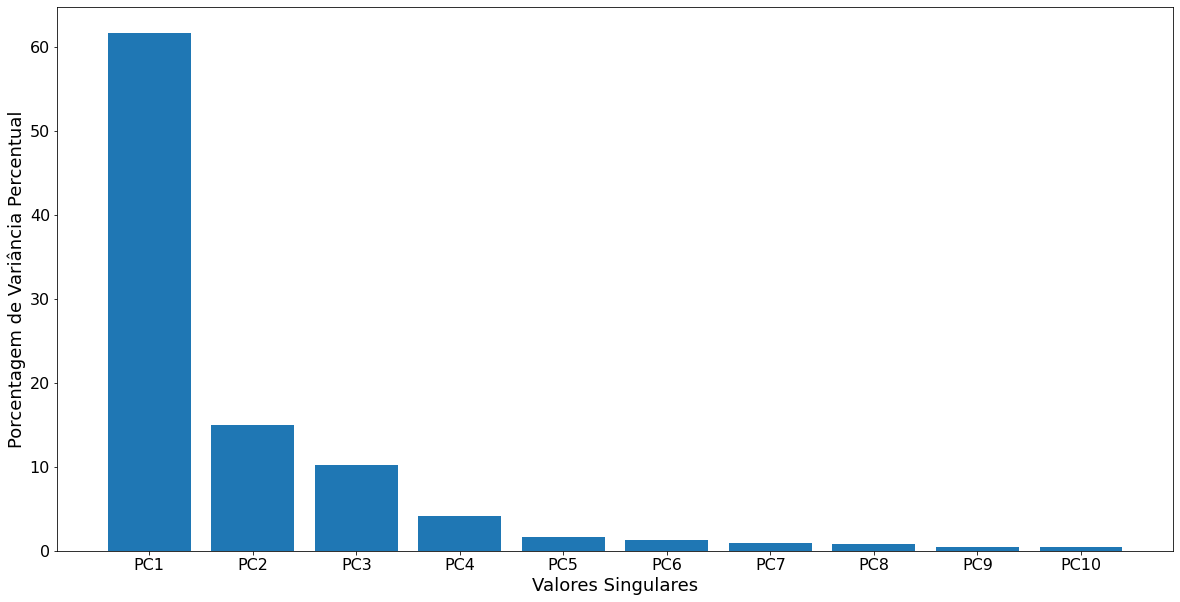

In [ ]:
#Geração de gráfico de distribuição de informação do PCA
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
print(per_var)
labels = ['PC' + str(x) for x in range(1, 11)]

plt.bar(x=range(1, 11), height=per_var[0:10], tick_label=labels)
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.ylabel('Porcentagem de Variância Percentual', fontsize = 18)
plt.xlabel('Valores Singulares', fontsize = 18)
plt.show()

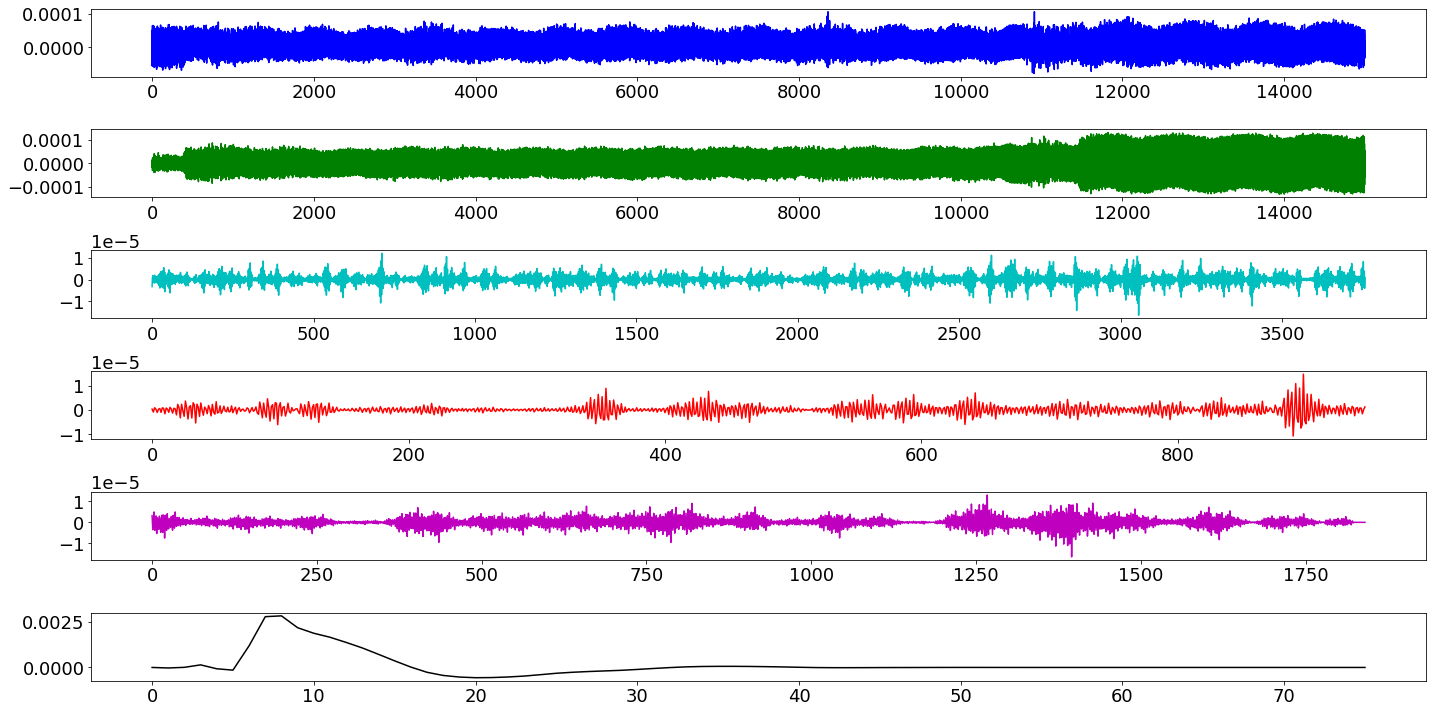

In [ ]:
#geração de gráfico de decomposição
import matplotlib.pyplot as plt

all_segmented_signals = np.load('/content/gdrive/MyDrive/Colab_Notebooks/TCC2_repository/resultados/all_segmented_signals.npy', allow_pickle=True)
approx_coeff, detail_coeff = dwt(all_segmented_signals[3][0][0][120], 5, 'sym6')
plt.rcParams['figure.figsize'] = [20,10]
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.subplot(611)
plt.plot(range(len(detail_coeff[0])),detail_coeff[0], 'b')
plt.subplot(612)
plt.plot(range(len(detail_coeff[1])),detail_coeff[1], 'g')
plt.subplot(613)
plt.plot(range(len(detail_coeff[2])),detail_coeff[2], 'c')
plt.subplot(614)
plt.plot(range(len(detail_coeff[3])),detail_coeff[3], 'r')
plt.subplot(615)
plt.plot(range(len(detail_coeff[4])),detail_coeff[4], 'm')
plt.subplot(616)
plt.plot(range(len(approx_coeff[4])),approx_coeff[4], 'k')
plt.tight_layout()
plt.show()




In [ ]:
#Verificação de ensaios sem estímulos
from google.colab import drive
import numpy as np

drive.mount('/content/gdrive', force_remount=True)
all_segmented_signals = np.load('/content/gdrive/MyDrive/Colab_Notebooks/TCC2_repository/resultados/all_segmented_signals.npy', allow_pickle=True)
for i in range(len(all_segmented_signals)):
  print(f'{i} Tem conteúdo vazio: {all_segmented_signals[i]==[]}')

Mounted at /content/gdrive


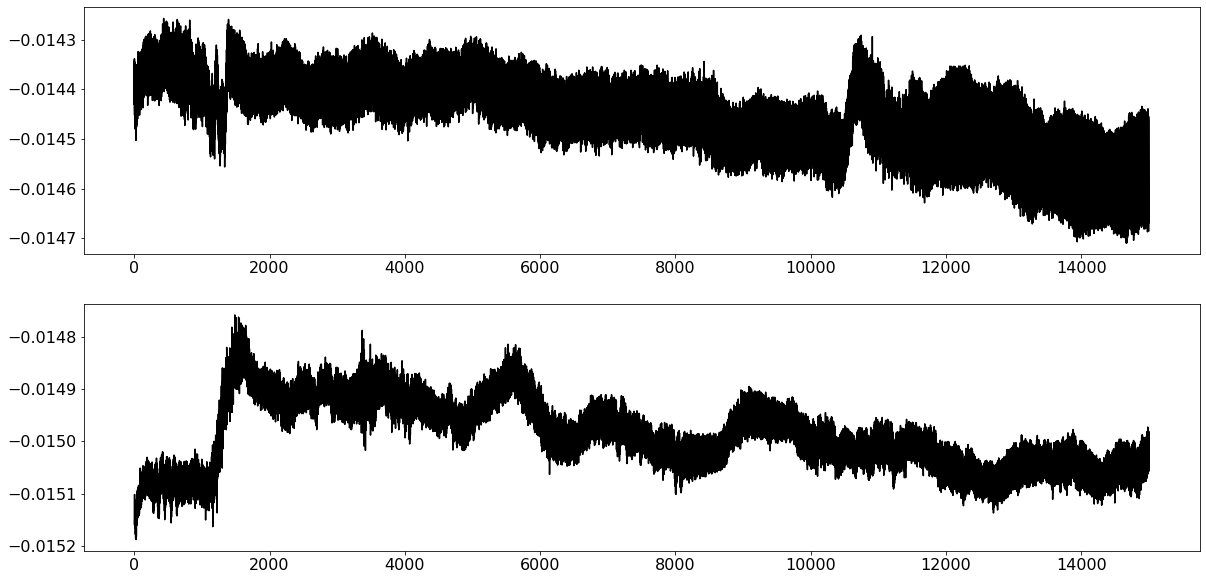

In [ ]:
#Geração de gráfico para comparação de estímulos sem tratamento nos sianis
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)
all_segmented_signals = np.load('/content/gdrive/MyDrive/Colab_Notebooks/TCC2_repository/resultados/all_segmented_signals.npy', allow_pickle=True)
plt.subplot(211)
plt.plot(range(len(all_segmented_signals[3][0][0][0])),all_segmented_signals[3][0][0][120], 'k')
plt.subplot(212)
plt.plot(range(len(all_segmented_signals[3][1][0][120])),all_segmented_signals[3][1][0][120], 'k')

In [9]:
#Manipulação dos dados obtidos
from random import seed
from sklearn.svm import SVC
from numpy.lib.twodim_base import tril_indices
import pandas as pd
import csv
import numpy as np
from numpy import array
import os, os.path
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA, FastICA
from google.colab import drive
import os, os.path
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier

event_test_X = []
event_X = []
X = []
y = []
y_name = []
y_events = []

#importando dados de etapas anteriores
drive.mount('/content/gdrive', force_remount=True)
raw_X = np.load('/content/gdrive/MyDrive/Colab_Notebooks/TCC2_repository/resultados/trial_approx_coeff_matrix.npy', allow_pickle=True)
events_classification = pd.read_csv('/content/gdrive/MyDrive/Colab_Notebooks/TCC2_repository/estimulos/stimulus_classification_new.csv')
matrixguide = pd.read_csv('/content/gdrive/MyDrive/Colab_Notebooks/TCC2_repository/resultados/matrix_guide.csv')
classificacao = pd.read_csv('/content/gdrive/MyDrive/Colab_Notebooks/TCC2_repository/estimulos/classificacao.csv')


events = array(pd.DataFrame(matrixguide, columns= ['1'],dtype= str))

#adequando o tamanho da matriz de resultados
for i in range(len(events)):
  y_events.append(events[i][0])


print(y_events)
print(f'events shape = {np.shape(events)}')

#label of dots
stimulus_name = array(pd.DataFrame(events_classification, columns= ['stimuliName'],dtype= str))


#valores de escala valência, excitação e dominância
valence = array(pd.DataFrame(events_classification, columns= ['valence'],dtype= float))
arousal = array(pd.DataFrame(events_classification, columns= ['arousal'],dtype= float ))
dominance = array(pd.DataFrame(events_classification, columns= ['dominance'],dtype= float ))
label = array(pd.DataFrame(classificacao, columns= ['label'], dtype= str))
print(pd.DataFrame(classificacao))

#loop para agrupar os eventos sem os ensaios
for i in range(len(raw_X)):
  for j in range(len(raw_X[i])):
      event_X.append(raw_X[i][j])

print(f'Event_X shape {np.shape(event_X)}')

#loop para popular X
for i in range(len(event_X)):
  z = []
  for j in range(len(event_X[i])):
    for k in range(len(event_X[i][j])):
      z.append(event_X[i][j][k])
  X.append(z)

print(np.ndim(valence))
print(np.shape(valence))

y_valence = []
y_arousal = []
y_dominance = []
#loop para popular y
for i in range(len(valence)):
  v = []
  a = []
  d = []
  v.append(valence[i][0])
  a.append(arousal[i][0])
  d.append(dominance[i][0])
  y_valence.append(v)
  y_arousal.append(a)
  y_dominance.append(d)


label_emotion = []

#ponto médio de cada escala
#valência
i = 5
#excitação
j = 5.1999999
#dominância
h = 4.0

#determinando as emoções com relação ao PAD
print(valence[0][0])
for k in range(len(valence)):
  if y_valence[k][0]>=i and y_arousal[k][0]>=j:
    if y_dominance[k][0]>=h:
      label_emotion.append("ALEGRE")
    else: 
      label_emotion.append("SURPRESO")
  elif y_valence[k][0]>=i and y_arousal[k][0]<j:
    if y_dominance[k][0]>=h:
      label_emotion.append("SATISFEITO")
    else:  
      label_emotion.append("PROTEGIDO")
  elif y_valence[k][0]<i and y_arousal[k][0]>=j:
    if y_dominance[k][0]>=h:
      label_emotion.append("DESPREOCUPADO")
    else:
      label_emotion.append("TRISTE")
  elif y_valence[k][0]<i and y_arousal[k][0]<j:
    if y_dominance[k][0]>=h:
      label_emotion.append("BRAVO")
    else:  
      label_emotion.append("MEDO")
print(f"i = {i} and j = {j}")
print(label_emotion)

#Dividindo os dados para teste e treino (proporção 80% treino e 20% teste)
treino_x, teste_x, treino_y, teste_y = train_test_split(X, label_emotion, 
                                                    test_size = 0.20, random_state=3)

print(f'treino_x shape = {np.shape(treino_x)}')
print(f'treino_y shape = {np.shape(treino_y)}')
print(f'teste_x shape = {np.shape(teste_x)}')
print(f'teste_y shape = {np.shape(teste_y)} ')

Mounted at /content/gdrive
["['neutral_1_1']", "['12_2']", "['8_3']", "['4_4']", "['15_5']", "['17_6']", "['16_7']", "['neutral_2_8']", "['7_9']", "['2_10']", "['24_11']", "['neutral_1_1']", "['1_2']", "['13_3']", "['9_4']", "['5_5']", "['neutral_2_6']", "['15_7']", "['23_8']", "['8_9']", "['4_10']", "['7_11']", "['neutral_1_1']", "['27_2']", "['15_3']", "['neutral_1_1']", "['15_2']", "['neutral_1_1']", "['5_2']", "['2_2']", "['13_2']", "['9_3']", "['5_4']", "['neutral_1_1']", "['8_2']", "['7_3']", "['neutral_2_4']", "['13_5']", "['neutral_1_1']", "['9_2']", "['15_3']", "['4_4']", "['5_5']", "['neutral_1_1']", "['2_2']", "['4_3']", "['neutral_1_1']", "['16_2']", "['24_3']", "['neutral_2_4']", "['17_5']", "['27_6']", "['2_7']", "['neutral_1_1']", "['5_2']", "['8_3']", "['12_4']", "['neutral_2_5']", "['4_6']", "['13_2']", "['24_3']", "['1_4']", "['4_2']", "['9_3']", "['13_4']", "['neutral_1_1']", "['4_2']", "['9_3']", "['8_4']", "['17_5']", "['13_6']", "['3_7']", "['12_8']", "['neutral_2

In [ ]:
#loop para descobrir melhor ponto intermediário
winner = []
accuracy_array = [0]
for i in np.arange(4.0,5.5,0.1):
  for j in np.arange(4.0,5.5,0.1):
    for h in np.arange(4.0,5.5,0.1):
      label_testing = []
      for k in range(len(valence)):
        if y_valence[k]>=i and y_arousal[k]>=j:
          if y_dominance[k]>=h:
            label_testing.append("ALEGRE")
          else: 
            label_testing.append("SURPRESO")
        elif y_valence[k]>=i and y_arousal[k]<j:
          if y_dominance[k]>=h:
            label_testing.append("SATISFEITO")
          else:  
            label_testing.append("PROTEGIDO")
        elif y_valence[k]<i and y_arousal[k]>=j:
          if y_dominance[k]>=h:
            label_testing.append("DESPREOCUPADO")
          else:
            label_testing.append("TRISTE")
        elif y_valence[k]<i and y_arousal[k]<j:
          if y_dominance[k]>=h:
            label_testing.append("BRAVO")
          else:  
            label_testing.append("MEDO")
      print(f"i = {i} and j = {j} and {h}")
      treino_x, teste_x, treino_y, teste_y = train_test_split(X, label_testing, 
                                                          test_size = 0.20, random_state=3)

      model = SVC()
      neigh = KNeighborsClassifier()

      #seting the training variables
      model.fit(treino_x,treino_y)
      prediction = model.predict(teste_x)

      #real prediction
      prediction.view()
      accuracy = accuracy_score(teste_y, prediction) * 100


      print(accuracy)
      print(max(accuracy_array))
      if(accuracy> max(accuracy_array)):
        print(f'Winner accuracy is: {accuracy}, with the medium valance value of {i}, arousal {j} and dominance {h}')
        winner = [accuracy, i, j]
        dummy_stratified = DummyClassifier()
        dummy_stratified.fit(treino_x, treino_y)
        previsoes = dummy_stratified.predict(teste_x)
        accuracy_dummy = accuracy_score(teste_y, previsoes) * 100
        print(f'Dummy classifier = {accuracy_dummy}')   
        results_svm = pd.DataFrame({'Prediction': prediction, 'Real value': teste_y})
        print(results_svm)
        winner_label = label_testing
      accuracy_array.append(accuracy)
print(winner)

In [10]:
#knn e svm
from sklearn.metrics import confusion_matrix


print(f'X shape: {np.shape(X)}')
print(f'y_name shape: {np.shape(y_name)}')
print(f'y shape: {np.shape(y)}')
#print(f'y {array(y)}')



array(y).view()
array(teste_y).view()


model = SVC()
neigh = KNeighborsClassifier(n_neighbors=15)

#treino SVM
model.fit(treino_x,treino_y)
prediction = model.predict(teste_x)

#previsão SVM
prediction.view()
accuracy = accuracy_score(teste_y, prediction) * 100

#dummy prediction
dummy_stratified = DummyClassifier()
dummy_stratified.fit(treino_x, treino_y)
previsoes = dummy_stratified.predict(teste_x)
accuracy_dummy = accuracy_score(teste_y, previsoes) * 100



#KNN
neigh.fit(treino_x, treino_y)
prediction_knn = neigh.predict(teste_x)
accuracy_knn = accuracy_score(teste_y, prediction_knn) * 100

teste = confusion_matrix(teste_y, prediction)

#resultados da execução
print(f'Acurácia SVM = {accuracy}')
print(f'Acurácia KNN = {accuracy_knn}')
print(f'Acurácia dummy = {accuracy_dummy}')
results_svm = pd.DataFrame({'Prediction SVM': prediction, 'Prediction KNN': prediction_knn ,'Real value': teste_y})
print(results_svm)

X shape: (145, 17424)
y_name shape: (0,)
y shape: (0,)
Acurácia SVM = 58.620689655172406
Acurácia KNN = 58.620689655172406
Acurácia dummy = 37.93103448275862
   Prediction SVM Prediction KNN     Real value
0          ALEGRE         ALEGRE     SATISFEITO
1   DESPREOCUPADO  DESPREOCUPADO  DESPREOCUPADO
2   DESPREOCUPADO  DESPREOCUPADO  DESPREOCUPADO
3   DESPREOCUPADO     SATISFEITO           MEDO
4   DESPREOCUPADO  DESPREOCUPADO  DESPREOCUPADO
5          ALEGRE         ALEGRE         ALEGRE
6   DESPREOCUPADO  DESPREOCUPADO  DESPREOCUPADO
7   DESPREOCUPADO  DESPREOCUPADO  DESPREOCUPADO
8           BRAVO          BRAVO          BRAVO
9           BRAVO          BRAVO         ALEGRE
10         ALEGRE         ALEGRE      PROTEGIDO
11  DESPREOCUPADO  DESPREOCUPADO  DESPREOCUPADO
12  DESPREOCUPADO  DESPREOCUPADO           MEDO
13  DESPREOCUPADO  DESPREOCUPADO      PROTEGIDO
14  DESPREOCUPADO  DESPREOCUPADO         ALEGRE
15  DESPREOCUPADO  DESPREOCUPADO  DESPREOCUPADO
16  DESPREOCUPADO  DESPREO

In [11]:
#Matriz de confusão
def matrix_values(result_matrix, emotion):
  #iniciação dos valores derivados da matriz (falso negativo, falso positivo, verdadeiro negativo e verdadeiro positivo )
  fn = 0
  fp = 0
  vn = 0
  vp = 0
  index = np.where(labels == emotion)[0][0]
  vp = result_matrix[index,index]
  for i in range(len(result_matrix)):
    fn += result_matrix[index,i]
    fp += result_matrix[i,index]
  fn = fn - vp
  fp = fp - vp
  total = sum(sum(result_matrix))
  vn = total - fn - fp - vp

  #calculando métricas da matriz de confusão
  accuracy_matrix = (vp+vn)/total *100
  sensibility = vp/(vp + fn) *100
  precision = vp/(vp + fp) *100
  specificity = vn/(vn+fp) *100
  f1_score = 2*((precision*sensibility)/(precision+sensibility))
  print(f'{emotion}')
  print(f'vp = {vp}, vn = {vn}, fn = {fn} e fp = {fp}')
  print("Valores derivados da matriz")
  print(f'Acurácia = {accuracy_matrix:.2f}% \nSensibilidade = {sensibility:.2f}% \nPrecisão = {precision:.2f}% \nEspecificidade = {specificity:.2f}% \nF1-score = {f1_score:.2f} ')

['ALEGRE' 'BRAVO' 'DESPREOCUPADO' 'MEDO' 'PROTEGIDO' 'SATISFEITO' 'TRISTE']
ALEGRE
vp = 0.42857142857142855, vn = 5.166666666666667, fn = 0.5714285714285714 e fp = 0.8333333333333333
Valores derivados da matriz
Acurácia = 79.93% 
Sensibilidade = 42.86% 
Precisão = 33.96% 
Especificidade = 86.11% 
F1-score = 37.89 
BRAVO
vp = 0.3333333333333333, vn = 5.857142857142857, fn = 0.6666666666666667 e fp = 0.14285714285714285
Valores derivados da matriz
Acurácia = 88.44% 
Sensibilidade = 33.33% 
Precisão = 70.00% 
Especificidade = 97.62% 
F1-score = 45.16 
DESPREOCUPADO
vp = 1.0, vn = 3.738095238095238, fn = 0.0 e fp = 2.261904761904762
Valores derivados da matriz
Acurácia = 67.69% 
Sensibilidade = 100.00% 
Precisão = 30.66% 
Especificidade = 62.30% 
F1-score = 46.93 
MEDO
vp = 0.0, vn = 6.0, fn = 1.0 e fp = 0.0
Valores derivados da matriz
Acurácia = 85.71% 
Sensibilidade = 0.00% 
Precisão = nan% 
Especificidade = 100.00% 
F1-score = nan 
PROTEGIDO
vp = 0.0, vn = 6.0, fn = 1.0 e fp = 0.0
Valor

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


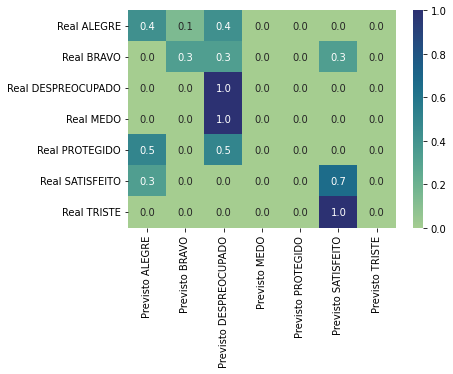

In [13]:
#Gerando matriz de confusão
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import seaborn as sns

result_matrix = confusion_matrix(teste_y, prediction, normalize='true')
labels= unique_labels(teste_y)
np.insert(labels, 6, 'SURPRESO')
print(labels)
colunas = [f'Previsto {label}' for label in labels]
indeces = [f'Real {label}' for label in labels]
table = pd.DataFrame(result_matrix, 
                      columns = colunas, index = indeces)
sns.heatmap(table, annot= True, fmt = '.1f', cmap='crest' )
for emotion in labels:
  matrix_values(result_matrix, emotion)

